# Gradient Boosting (XGBoost)

In [25]:
# Libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import joblib
import numpy as np

## 1. Loading the Data

In [2]:
df = pd.read_csv('..\\data\\processed\\final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)

df.columns

Index(['Hour', 'Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)', 'IsPublicHoliday', 'temp', 'humidity', 'rain_1h',
       'clouds_all', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Weekday_7', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [3]:
# Feature Scaling
scaler = MinMaxScaler()
weather_features = ['temp', 'humidity', 'rain_1h', 'clouds_all']
df[weather_features] = scaler.fit_transform(df[weather_features])

# print(data[weather_features].describe())

## 2. Feature Selection

In [4]:
# Separate features and target
target_columns = [
    'Little Collins St-Swanston St (East)', 
    'Faraday St-Lygon St (West)', 
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)'
]

# Add lagged features (they capture pedestrian flow from the previous hour)
for sensor in target_columns:
    df[f'{sensor}_Lag_1'] = df[sensor].shift(1)

# Add rolling averages (capture the short term trends over the last 7 hours)
for sensor in target_columns:
    df[f'Rolling_7_{sensor}'] = df[sensor].rolling(window=7, min_periods=1).mean()


In [5]:
#Editing the feature list
# Adding hour as a feature
df['Hour'] = df.index.hour

# interaction feature
df['Rain_Holiday'] = df['rain_1h'] * df['IsPublicHoliday']

features = [
    'IsPublicHoliday', 'Hour',
    'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7',
    'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
    'Season_Spring', 'Season_Summer', 'Season_Winter',
    'temp', 'humidity', 'rain_1h', 'clouds_all'
] + \
[f'Rolling_7_{sensor}' for sensor in target_columns] + \
[f'{sensor}_Lag_1' for sensor in target_columns]

In [7]:
# Split into train and test sets
train = df[df.index < "2024-05-01"]
test = df[df.index >= "2024-05-01"]

X_train = train[features]
X_test = test[features]
y_train = train[target_columns]
y_test = test[target_columns]


print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (18264, 36), y_train: (18264, 5)
X_test: (4416, 36), y_test: (4416, 5)


## 3. Model

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [10]:
models = {}

for sensor in target_columns:
    print(f"Training model for {sensor}...")
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=100,             
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    
    model.fit(X_train, y_train[sensor])
    models[sensor] = model
    print(f"Completed training for {sensor}")

Training model for Little Collins St-Swanston St (East)...
Completed training for Little Collins St-Swanston St (East)
Training model for Faraday St-Lygon St (West)...
Completed training for Faraday St-Lygon St (West)
Training model for Melbourne Central...
Completed training for Melbourne Central
Training model for Chinatown-Lt Bourke St (South)...
Completed training for Chinatown-Lt Bourke St (South)
Training model for Lonsdale St (South)...
Completed training for Lonsdale St (South)


In [11]:
# Model Evaluation
for sensor in target_columns:
    predictions = models[sensor].predict(X_test)
    
    # Metrics
    rmse = root_mean_squared_error(y_test[sensor], predictions)
    mape = mean_absolute_percentage_error(y_test[sensor], predictions)
    r2 = r2_score(y_test[sensor], predictions)
    
    # Print metrics
    print(f"Evaluation for {sensor}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}")
    print(f"  R²: {r2}")


Evaluation for Little Collins St-Swanston St (East):
  RMSE: 120.98549984495062
  MAPE: 1253553875873614.2
  R²: 0.9637725450082357
Evaluation for Faraday St-Lygon St (West):
  RMSE: 31.38757961338236
  MAPE: 555788421759926.0
  R²: 0.9713284044056746
Evaluation for Melbourne Central:
  RMSE: 139.6879323698401
  MAPE: 357958540522718.8
  R²: 0.9781942425508837
Evaluation for Chinatown-Lt Bourke St (South):
  RMSE: 71.83795777916202
  MAPE: 6890805836268232.0
  R²: 0.944830100724928
Evaluation for Lonsdale St (South):
  RMSE: 50.161246891908405
  MAPE: 699362814307936.6
  R²: 0.972987872223629


## 4. Hyperparamter Tuning

In [12]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400]
}

In [13]:
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_grid,
    n_iter=30,                         # Randomly sample 30 combinations
    scoring='neg_mean_squared_error',  # Minimize RMSE
    verbose=2,
    n_jobs=-1
)

In [14]:
tuned_models = {}

for sensor in target_columns:
    print(f"Optimizing hyperparameters for {sensor}...")
    random_search.fit(X_train, y_train[sensor])
    
    # Save the best model
    tuned_models[sensor] = random_search.best_estimator_
    print(f"Best parameters for {sensor}: {random_search.best_params_}")

Optimizing hyperparameters for Little Collins St-Swanston St (East)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best parameters for Little Collins St-Swanston St (East): {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Optimizing hyperparameters for Faraday St-Lygon St (West)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Faraday St-Lygon St (West): {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Optimizing hyperparameters for Melbourne Central...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Melbourne Central: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Optimizing hyperparameters for Chinatown-Lt Bourke St (South)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for Chinatown-Lt Bourke St (South): {'subsample': 1.0, 'n

In [15]:
# Save the best model
import joblib

# Save trained models
for sensor, model in tuned_models.items():
    joblib.dump(model, f"{sensor}_xgboost_model.pkl")

print("Trained models saved as pickle files.")


Trained models saved as pickle files.


## 5. Cross-Validation

We use TimeSeriesSplit for cross-validation with RandomSearchVC

In [16]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5) 
random_search.cv = tscv     

In [17]:
for sensor in target_columns:
    print(f"Cross-validating model for {sensor}...")
    random_search.cv = tscv
    random_search.fit(X_train, y_train[sensor])
    
    # Save the cross-validated model
    tuned_models[sensor] = random_search.best_estimator_
    print(f"Cross-validated best parameters for {sensor}: {random_search.best_params_}")


Cross-validating model for Little Collins St-Swanston St (East)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Cross-validated best parameters for Little Collins St-Swanston St (East): {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Cross-validating model for Faraday St-Lygon St (West)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Cross-validated best parameters for Faraday St-Lygon St (West): {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Cross-validating model for Melbourne Central...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Cross-validated best parameters for Melbourne Central: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Cross-validating model for Chin

## 6. Evaluation of tuned models

In [39]:
# for sensor in target_columns:
#     predictions = tuned_models[sensor].predict(X_test)
#     rmse = root_mean_squared_error(y_test[sensor], predictions)
#     mape = mean_absolute_percentage_error(y_test[sensor], predictions)
#     r2 = r2_score(y_test[sensor], predictions)

#     print(f"Performance for {sensor}:")
#     print(f"  RMSE: {rmse}")
#     print(f"  MAPE: {mape}")
#     print(f"  R²: {r2}")

In [35]:
def weighted_mape(y_true, y_pred):
    weights = y_true / y_true.sum()
    return np.sum(weights * np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
def adjusted_mape(y_true, y_pred, threshold=10):
    # Exclude small actual values below the threshold
    mask = y_true > threshold
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [ ]:
for sensor in target_columns:
    predictions = tuned_models[sensor].predict(X_test)

    # All metrics
    rmse = root_mean_squared_error(y_test[sensor], predictions)
    mape = mean_absolute_percentage_error(y_test[sensor], predictions)
    adj_mape = adjusted_mape(y_test[sensor], predictions, threshold=10)
    w_mape = weighted_mape(y_test[sensor], predictions)
    r2 = r2_score(y_test[sensor], predictions)
    
    print(f"Performance for {sensor}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}")
    print(f"  Adjusted MAPE: {adj_mape}")
    print(f"  Weighted MAPE: {w_mape}")
    print(f"  R²: {r2}")

Performance for Little Collins St-Swanston St (East):
  RMSE: 121.58444458143347
  MAPE: 1113101120216019.8
  Adjusted MAPE: 16.750856700544446
  Weighted MAPE: 9.97184181599073
  R²: 0.9634129655110508
Performance for Faraday St-Lygon St (West):
  RMSE: 31.61213089639928
  MAPE: 498498369566631.25
  Adjusted MAPE: 14.002119027879834
  Weighted MAPE: 9.581594660321633
  R²: 0.9709166954609789
Performance for Melbourne Central:
  RMSE: 140.25931738808492
  MAPE: 396087579537230.06
  Adjusted MAPE: 16.006871286506
  Weighted MAPE: 8.00635197073892
  R²: 0.9780154874460405
Performance for Chinatown-Lt Bourke St (South):
  RMSE: 74.69930162569003
  MAPE: 8540954451357280.0
  Adjusted MAPE: 19.72559761062345
  Weighted MAPE: 12.945794828175117
  R²: 0.9403476827539322
Performance for Lonsdale St (South):
  RMSE: 51.15812612715173
  MAPE: 719189534895475.1
  Adjusted MAPE: 13.016566731626417
  Weighted MAPE: 8.389630090620232
  R²: 0.9719035529137691


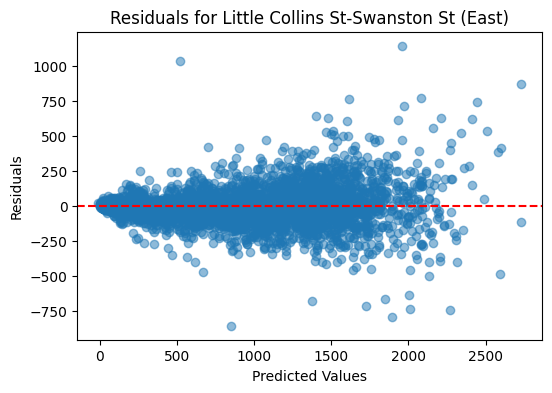

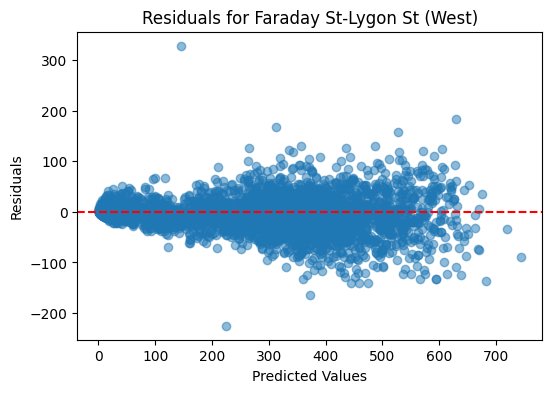

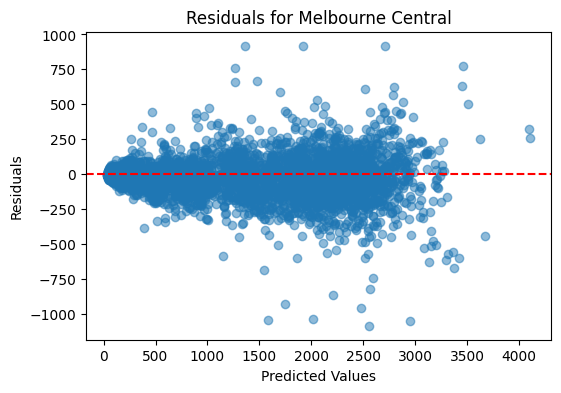

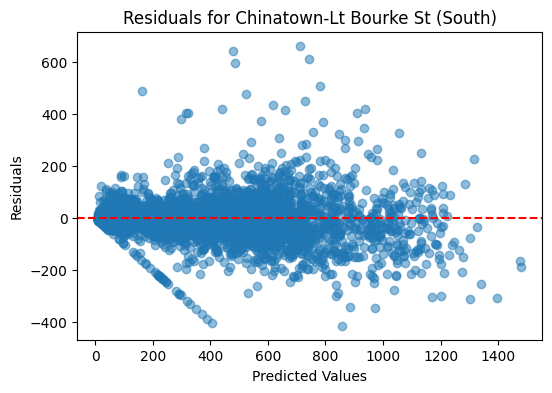

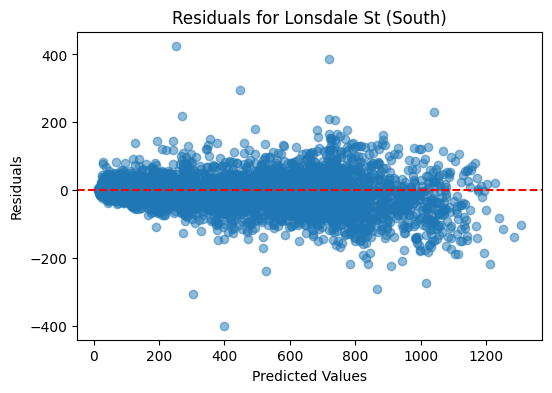

In [19]:
# Analysis of the Residuals
for sensor in target_columns:
    predictions = tuned_models[sensor].predict(X_test)
    residuals = y_test[sensor] - predictions

    # Scatter plot of residuals
    plt.figure(figsize=(6, 4))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals for {sensor}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()


## Predictions

In [20]:
all_predictions = {}

for sensor in target_columns:
    all_predictions[sensor] = tuned_models[sensor].predict(X_test)

predictions_df = pd.DataFrame(all_predictions, index=X_test.index)
predictions_df.to_csv("predictions.csv", index=True)
print("Predictions saved to predictions.csv.")

Predictions saved to predictions.csv.


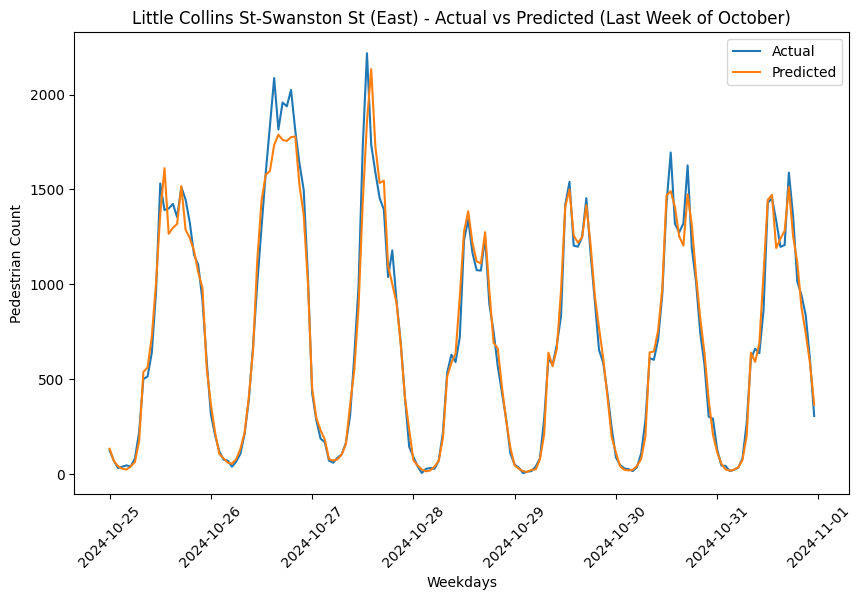

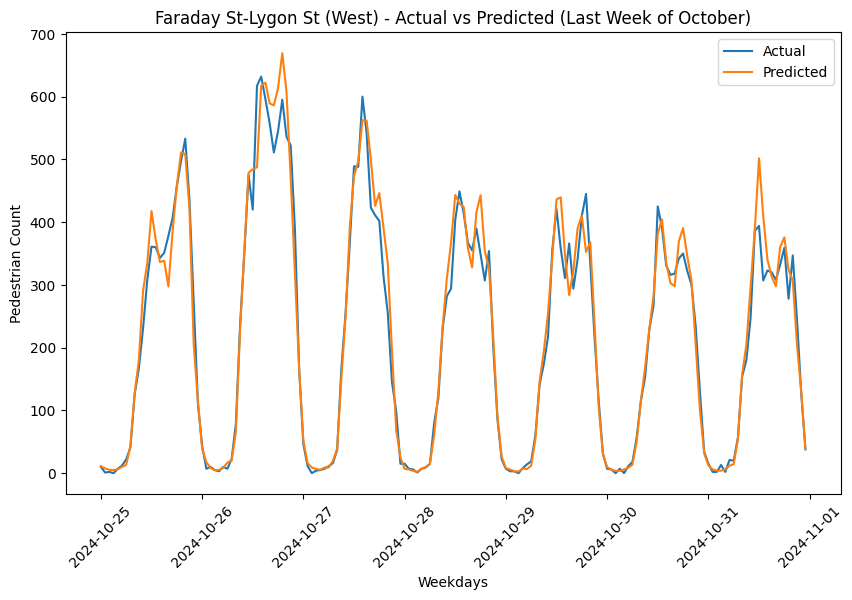

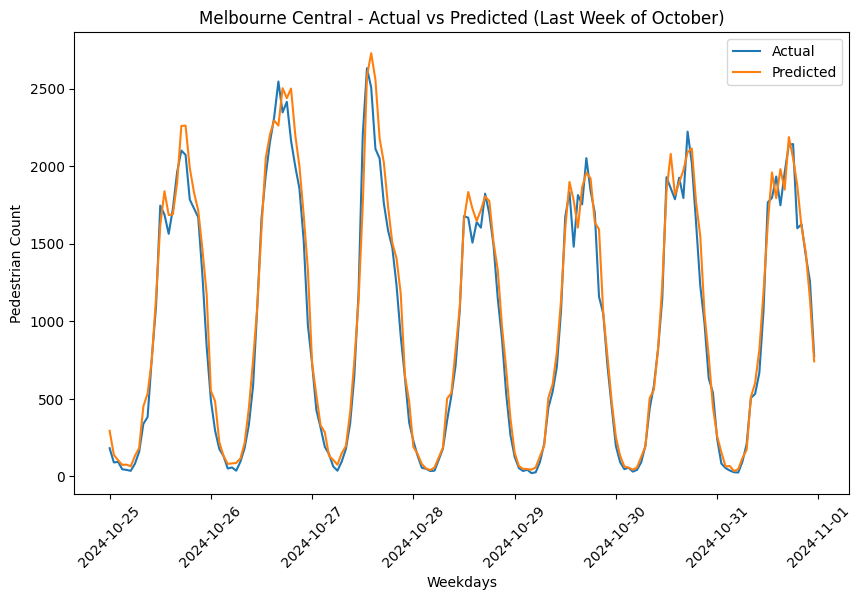

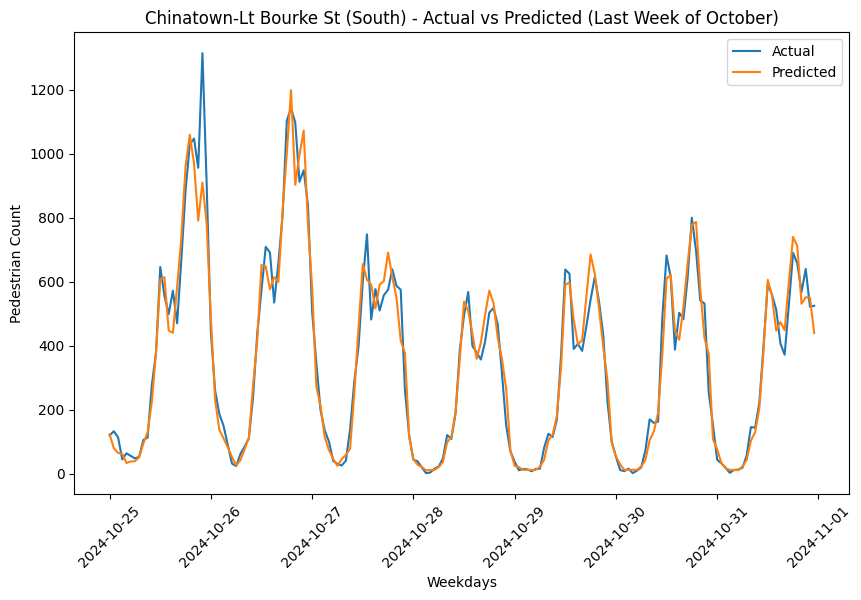

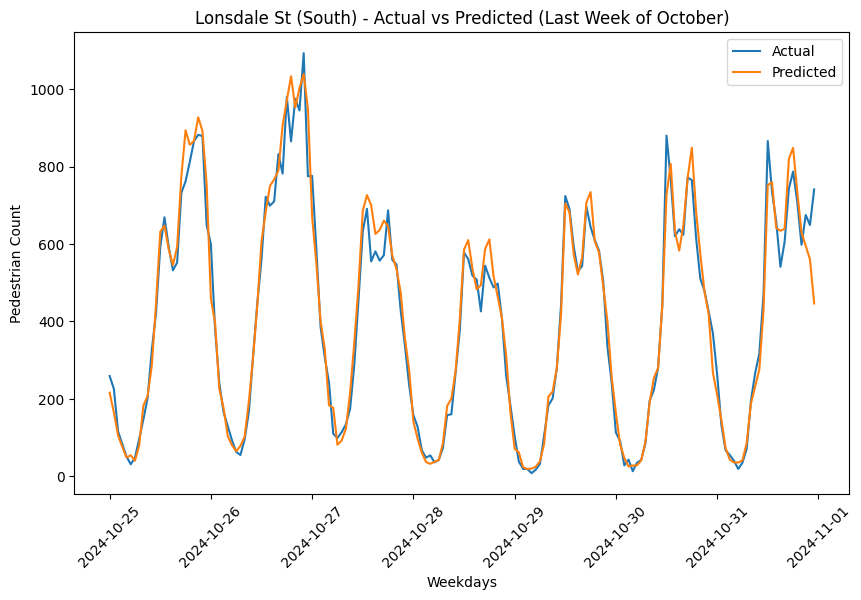

In [33]:
#Last october week
one_week_index = X_test.loc["2024-10-25":"2024-10-31"].index

# Generate plots for the last week of October
for sensor in target_columns:
    actual = y_test[sensor].loc[one_week_index]
    predicted = tuned_models[sensor].predict(X_test.loc[one_week_index])

    # Plot for one week
    plt.figure(figsize=(10, 6))
    plt.plot(one_week_index, actual, label="Actual")
    plt.plot(one_week_index, predicted, label="Predicted")
    plt.title(f"{sensor} - Actual vs Predicted (Last Week of October)")
    plt.xlabel("Weekdays")
    plt.xticks(rotation=45)
    plt.ylabel("Pedestrian Count")
    plt.legend()
    plt.show()

RSME fot weekly forecast

In [27]:
october_index = X_test.loc["2024-10-01":"2024-10-07"].index

# Calculate RMSE for October 1–7
for sensor in target_columns:
    actual = y_test[sensor].loc[october_index]
    predicted = tuned_models[sensor].predict(X_test.loc[october_index])
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    print(f"October Week RMSE for {sensor}: {rmse:.2f}")

October Week RMSE for Little Collins St-Swanston St (East): 191.57
October Week RMSE for Faraday St-Lygon St (West): 33.81
October Week RMSE for Melbourne Central: 181.99
October Week RMSE for Chinatown-Lt Bourke St (South): 80.52
October Week RMSE for Lonsdale St (South): 61.31


Overfitting Comparison

In [26]:
for sensor in target_columns:
    train_predictions = tuned_models[sensor].predict(X_train)
    test_predictions = tuned_models[sensor].predict(X_test)
    
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train[sensor], train_predictions))
    train_r2 = r2_score(y_train[sensor], train_predictions)
    
    # Testing metrics
    test_rmse = np.sqrt(mean_squared_error(y_test[sensor], test_predictions))
    test_r2 = r2_score(y_test[sensor], test_predictions)
    
    print(f"{sensor} - Training RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}")
    print(f"{sensor} - Testing RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")


Little Collins St-Swanston St (East) - Training RMSE: 18.55, R²: 1.00
Little Collins St-Swanston St (East) - Testing RMSE: 121.58, R²: 0.96
Faraday St-Lygon St (West) - Training RMSE: 4.91, R²: 1.00
Faraday St-Lygon St (West) - Testing RMSE: 31.61, R²: 0.97
Melbourne Central - Training RMSE: 98.90, R²: 0.99
Melbourne Central - Testing RMSE: 140.26, R²: 0.98
Chinatown-Lt Bourke St (South) - Training RMSE: 63.18, R²: 0.96
Chinatown-Lt Bourke St (South) - Testing RMSE: 74.70, R²: 0.94
Lonsdale St (South) - Training RMSE: 43.16, R²: 0.98
Lonsdale St (South) - Testing RMSE: 51.16, R²: 0.97
